In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer

# data_train = pd.read_csv("/content/sample_data/train.tsv", sep="\t", header=None)
# data_valid = pd.read_csv("/content/sample_data/valid.tsv", sep="\t", header=None)
# data_test = pd.read_csv("/content/sample_data/test.tsv", sep="\t", header=None)

!pip install transformers
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("liar")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading train, test and valid data from LIAR dataset

In [ ]:
train_df=pd.DataFrame(dataset['train'])
test_df=pd.DataFrame(dataset['test'])
validation_df=pd.DataFrame(dataset['validation'])


Add Additional column based on "Pants on fire" Count

In [ ]:
def evaluate_fake_news(count):
    if count > 20:
        return "This is most likely fake news"
    else:
        return "This is most likely not fake news"

# Apply the function and create the new column
train_df['news_evaluation'] = train_df['pants_on_fire_counts'].apply(evaluate_fake_news)
test_df['news_evaluation'] = test_df['pants_on_fire_counts'].apply(evaluate_fake_news)
validation_df['news_evaluation'] = validation_df['pants_on_fire_counts'].apply(evaluate_fake_news)

In [ ]:
#Viewing sample train data before preprocessing
train_df.head(5)

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,news_evaluation
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,This is most likely not fake news
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,This is most likely not fake news
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,This is most likely not fake news
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release,This is most likely fake news
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,This is most likely not fake news


Data Preprocessing

In [ ]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x==3 or x==2 else 0 for x in dataset['label']]
  #Dropping unwanted columns
  dataset = dataset.drop(labels=['id','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts'] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset['subject'][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset['speaker'][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset['job_title'][i]
      if job == 0:
          job = 'None'

      state =  dataset['state_info'][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset['party_affiliation'][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset['context'][i]
      if context == 0 :
          context = 'None'

      news_evaluation =  dataset['news_evaluation'][i]
      if news_evaluation == 0 :
          news_evaluation = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context) + ' ' + str(news_evaluation)) #combining all the meta data columns into a single column

  #Adding cleaned and combined metadata column to the dataset
  dataset['meta'] = meta
  dataset["sentence"] = dataset['meta'].astype('str')+" "+dataset['statement'] #Combining metadata and the text columns into single columns

  dataset = dataset.drop(['statement',	'subject',	'speaker',	'job_title',	'state_info',	'party_affiliation',	'context','meta' , 'news_evaluation' ], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset



In [ ]:
# str(train_df.loc[1][0])+ ","+ str(train_df.loc[1][2])

In [ ]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train = data_preprocessing(train_df)
data_valid = data_preprocessing(validation_df)
data_test = data_preprocessing(test_df)

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data_train['sentence']=data_train['sentence'].apply(lambda x:review_cleaning(x))
data_test['sentence']=data_test['sentence'].apply(lambda x:review_cleaning(x))
data_valid['sentence']=data_valid['sentence'].apply(lambda x:review_cleaning(x))

data_train.head()

,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting none a news release t...
4,0,economyjobs charliecrist florida democrat an ...


In [ ]:
stop = stopwords.words('english')
data_train['sentence'] = data_train['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_test['sentence'] = data_test['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_valid['sentence'] = data_valid['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_train.head()

,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting none news release likel...
4,0,economyjobs charliecrist florida democrat inte...


In [ ]:
# label_1 = data_train[data_train['label'] == 1]
# label_0 = data_train[data_train['label'] == 0]

# # finding the sampling size of the data so that both the
# sample_size = min(len(label_1), len(label_0))
# label_1_sample = label_1.sample(n=sample_size, random_state=42)
# label_0_sample = label_0.sample(n=sample_size, random_state=42)

# # Combine the sampled subsets to create a balanced dataset
# data_train = pd.concat([label_1_sample, label_0_sample], ignore_index=True)
# data_train = data_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# label_1 = data_test[data_test['label'] == 1]
# label_0 = data_test[data_test['label'] == 0]

# # finding the sampling size of the data so that both the
# sample_size = min(len(label_1), len(label_0))
# label_1_sample = label_1.sample(n=sample_size, random_state=42)
# label_0_sample = label_0.sample(n=sample_size, random_state=42)

# # Combine the sampled subsets to create a balanced dataset
# data_test = pd.concat([label_1_sample, label_0_sample], ignore_index=True)
# data_test = data_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# label_1 = data_valid[data_valid['label'] == 1]
# label_0 = data_valid[data_valid['label'] == 0]

# # finding the sampling size of the data so that both the
# sample_size = min(len(label_1), len(label_0))
# label_1_sample = label_1.sample(n=sample_size, random_state=42)
# label_0_sample = label_0.sample(n=sample_size, random_state=42)

# # Combine the sampled subsets to create a balanced dataset
# data_valid = pd.concat([label_1_sample, label_0_sample], ignore_index=True)
# data_valid = data_valid.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#Sample data after preprocessing
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(10269, 2)
(1284, 2)
(1283, 2)


In [ ]:
data_train['sentence'][0]

'abortion dwaynebohac state representative texas republican mailer likely fake news says annies list political group supports thirdtrimester abortions demand'

Analyzing the distribtuion of labels in each dataset


In [ ]:
data_train['label'].value_counts()

label
0    6620
1    3649
Name: count, dtype: int64

In [ ]:
data_valid['label'].value_counts()

label
0    864
1    420
Name: count, dtype: int64

In [ ]:
data_test['label'].value_counts()

label
0    823
1    460
Name: count, dtype: int64

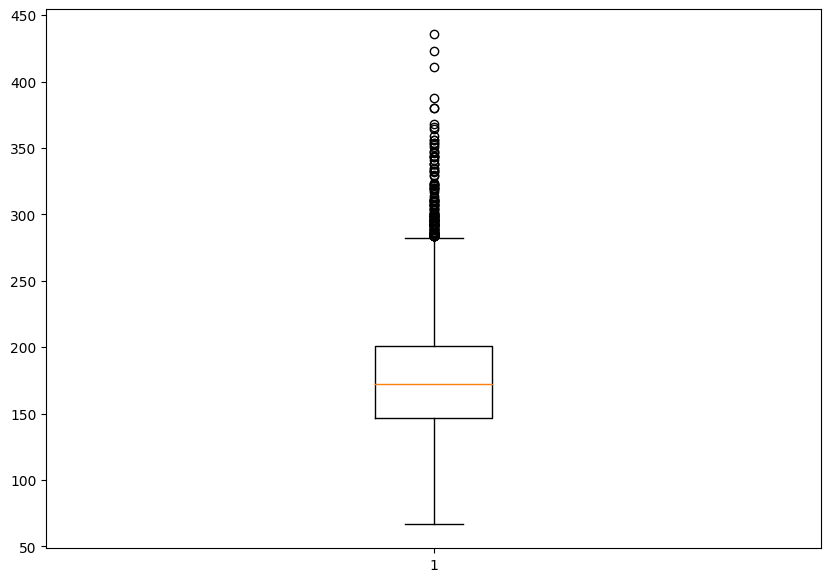

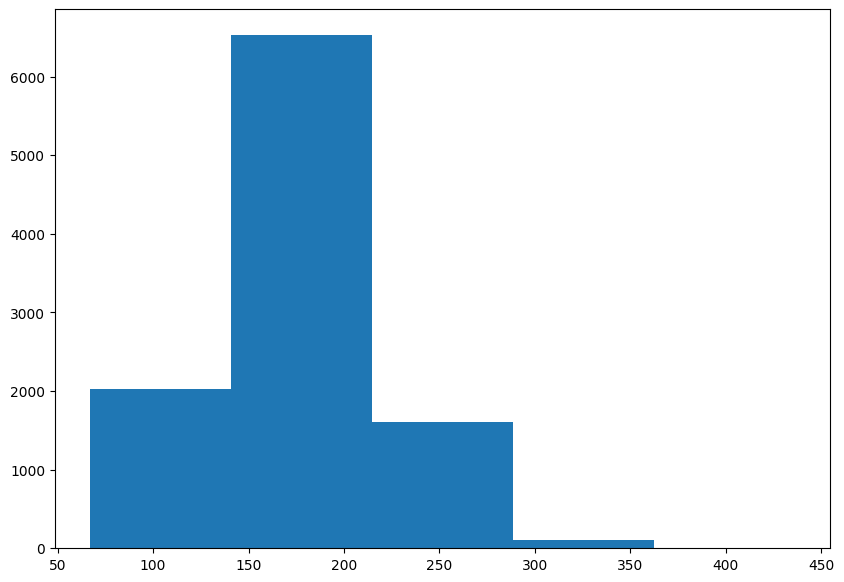

In [ ]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for BERT and RoBERTa

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

From the above histogram, we can see that, majority of the sentences are in the range of 150-250 and most of the sentences length is less than 350

Installing required library - transformers

In [ ]:
!pip install transformers


In [ ]:
#importing required packages
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW)

In [ ]:
# Loading BERT base model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", #Using BERT base model with an uncased vocab.
                                                                num_labels = 2, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                          )
#BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()

# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
                                                                    num_labels = 2,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' Base models loaded')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Base models loaded


Demonstrating how BERT and RoBERTa tokenizers work on a sample sentence

In [ ]:
# Print the original sentence.
print(' Original: ', data_train["sentence"][0])

# Split the sentence into tokens - BERT
print('Tokenized BERT: ', bert_tokenizer.tokenize(data_train["sentence"][0]))

# Mapping tokens to token IDs - BERT
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(data_train["sentence"][0])))

# Split the sentence into tokens -RoBERTa
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(data_train["sentence"][0]))

# Mapping tokens to token IDs - RoBERTa
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(data_train["sentence"][0])))


 Original:  abortion dwaynebohac state representative texas republican mailer likely fake news says annies list political group supports thirdtrimester abortions demand
Tokenized BERT:  ['abortion', 'd', '##way', '##ne', '##bo', '##ha', '##c', 'state', 'representative', 'texas', 'republican', 'mail', '##er', 'likely', 'fake', 'news', 'says', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '##tri', '##mes', '##ter', 'abortion', '##s', 'demand']
Token IDs BERT:  [11324, 1040, 4576, 2638, 5092, 3270, 2278, 2110, 4387, 3146, 3951, 5653, 2121, 3497, 8275, 2739, 2758, 8194, 2015, 2862, 2576, 2177, 6753, 2353, 18886, 7834, 3334, 11324, 2015, 5157]
Tokenized RoBERT:  ['abortion', 'Ġd', 'wayne', 'b', 'oh', 'ac', 'Ġstate', 'Ġrepresentative', 'Ġtex', 'as', 'Ġrepublican', 'Ġmail', 'er', 'Ġlikely', 'Ġfake', 'Ġnews', 'Ġsays', 'Ġann', 'ies', 'Ġlist', 'Ġpolitical', 'Ġgroup', 'Ġsupports', 'Ġthird', 'tr', 'imester', 'Ġabortions', 'Ġdemand']
Token IDs RoBERTa:  [27275, 385, 20143, 428,

In [ ]:
#assigning sentences and labels to separate variables
sentences = data_train["sentence"].values
labels = data_train["label"].values

In [ ]:
import torch

In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = dataset["sentence"].values
  labels = dataset["label"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids
      bert_encoded_dict = bert_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,     #Since we have seen from our analysis that majority of sentences have length less than 300.
                          pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                          pad_to_max_length = True,     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )


      # Add the encoded sentence to the list.
      bert_input_ids.append(bert_encoded_dict['input_ids'])
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])


      # Add attention mask to the list
      bert_attention_masks.append(bert_encoded_dict['attention_mask'])
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])


      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1



  # Convert the lists into tensors.
  bert_input_ids = torch.cat(bert_input_ids, dim=0)
  bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {"Bert":[bert_input_ids, bert_attention_masks, labels], "Roberta":[roberta_input_ids, roberta_attention_masks, labels]}


In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(data_train)

bert_input_ids,bert_attention_masks,labels = token_dict_train["Bert"]
roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(data_valid)

bert_input_ids_valid,bert_attention_masks_valid,labels_valid = token_dict_valid["Bert"]
roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)

bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
# Combine the training inputs into a TensorDataset.
bert_train_dataset = TensorDataset( bert_input_ids, bert_attention_masks, labels)
roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
bert_val_dataset = TensorDataset(bert_input_ids_valid,bert_attention_masks_valid,labels_valid)
roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

In [ ]:
# Combine the test inputs into a TensorDataset.
bert_test_dataset = TensorDataset(bert_input_ids_test,bert_attention_masks_test,labels_test)
roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoaders for our validation - Loads the data in batches of size 32
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# optimizers - AdamW
# here, i have used default learning rate and epsilon values for both BERT and RoBERTa
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 15

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


BERT - Training and Validation

In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
      #Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # print current training batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        bert_model.zero_grad()

        outputs = bert_model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # model returns a tuple, extract loss value from that tuple
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()

        bert_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    #Validation Part


    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    bert_model.eval()
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
           outputs = bert_model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 15 ========
Training...
  Batch    40  of    321.    Elapsed: 0:00:25.
  Batch    80  of    321.    Elapsed: 0:00:50.
  Batch   120  of    321.    Elapsed: 0:01:15.
  Batch   160  of    321.    Elapsed: 0:01:41.
  Batch   200  of    321.    Elapsed: 0:02:06.
  Batch   240  of    321.    Elapsed: 0:02:33.
  Batch   280  of    321.    Elapsed: 0:02:59.
  Batch   320  of    321.    Elapsed: 0:03:25.

  Average training loss: 0.64
  Training epcoh took: 0:03:26

Running Validation...
  Accuracy: 0.68
  Validation took: 0:00:10

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    321.    Elapsed: 0:00:26.
  Batch    80  of    321.    Elapsed: 0:00:53.
  Batch   120  of    321.    Elapsed: 0:01:19.
  Batch   160  of    321.    Elapsed: 0:01:46.
  Batch   200  of    321.    Elapsed: 0:02:12.
  Batch   240  of    321.    Elapsed: 0:02:39.
  Batch   280  of    321.    Elapsed: 0:03:05.
  Batch   320  of    321.    Elapsed: 0:03:32.

  Average training loss: 0.59


In [ ]:
#Plotting the training loss over epochs
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

Testing Part


In [ ]:
bert_prediction_sampler = SequentialSampler(bert_test_dataset)
bert_prediction_dataloader = DataLoader(bert_test_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables
predictions , true_labels = [], []

Predicting labels for 1,283 test sentences...


In [ ]:
# Predict
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


Classsification Report and Confusion Matrix for Test set

In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       917
           1       0.41      0.51      0.46       366

    accuracy                           0.65      1283
   macro avg       0.60      0.61      0.60      1283
weighted avg       0.68      0.65      0.66      1283

[[645 178]
 [272 188]]


ROBERTA - Training and Validation

In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):

    # Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            #Printing current batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        roberta_model.zero_grad()

        outputs = roberta_model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # Model returns tuple, extract loss value from that tuple
        loss = outputs[0]

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()

        roberta_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(roberta_train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Validation

    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    roberta_model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = roberta_model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)


        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 15 ========
Training...
  Batch    40  of    321.    Elapsed: 0:00:27.
  Batch    80  of    321.    Elapsed: 0:00:53.
  Batch   120  of    321.    Elapsed: 0:01:20.
  Batch   160  of    321.    Elapsed: 0:01:47.
  Batch   200  of    321.    Elapsed: 0:02:13.
  Batch   240  of    321.    Elapsed: 0:02:40.
  Batch   280  of    321.    Elapsed: 0:03:07.
  Batch   320  of    321.    Elapsed: 0:03:34.

  Average training loss: 0.65
  Training epcoh took: 0:03:34

Running Validation...
  Accuracy: 0.67
  Validation took: 0:00:10

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    321.    Elapsed: 0:00:27.
  Batch    80  of    321.    Elapsed: 0:00:53.
  Batch   120  of    321.    Elapsed: 0:01:20.
  Batch   160  of    321.    Elapsed: 0:01:47.
  Batch   200  of    321.    Elapsed: 0:02:14.
  Batch   240  of    321.    Elapsed: 0:02:40.
  Batch   280  of    321.    Elapsed: 0:03:07.
  Batch   320  of    321.    Elapsed: 0:03:34.

  Average training loss: 0.65


Testing Part

In [ ]:
roberta_prediction_sampler = SequentialSampler(roberta_test_dataset)
roberta_prediction_dataloader = DataLoader(roberta_test_dataset, sampler=roberta_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables
predictions , true_labels = [], []

Predicting labels for 1,283 test sentences...


In [ ]:
# Predict
for batch in roberta_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():

      outputs = roberta_model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]


  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


Classification report and Confusion Matrix for test set

In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78      1283
           1       0.00      0.00      0.00         0

    accuracy                           0.64      1283
   macro avg       0.50      0.32      0.39      1283
weighted avg       1.00      0.64      0.78      1283

[[823   0]
 [460   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



This code was adapted from https://github.com/SindhuMadi/FakeNewsDetection